# Assignment 1: ODrive setup and initial kinematics exploration

In homework 1 we will learn the basic functionality of the ODrive motor controller and the kinematics of the 5-bar leg. There are 5 problems below. You will turn this assignment in by uploading it to your own github repository for this assignment and then sending a link to ngravish@eng.ucsd.edu with the subject MAE_207_HW1. The assignment is to be completed in pairs, one per team.

If you would like, you directly ```fork``` this repository into your github account, this is found in the upper right hand corner. You can then download the repository to your computer using the ```clone``` button on the right side. Once you are done with the assignment, commit the changes back to the github online repository. 

Alternatively you can just download the .ipynb file, edit it as you solve the problems, and then in the end upload to a github repo.

#### Team #: 1

#### Names: Zhaoliang Zheng & Dawoon Kim



## Problem 1: Familiarization with ODrive firmware

__1.1__ You should follow the instructions to flash the motor controller firmware found [here](https://github.com/madcowswe/ODrive).

__1.2__ In the ```Odrive/Firmware/MotorControl``` folder are the code files that control the motor. The most important file is ```low_level.c```. Find this file and familiarize yourself with it. 

__1.3__ In ```low_level.c``` the main function for motor control is ```control_motor_loop(Motor_t* motor)```. Find this function and copy and paste blocks of it into the cell below.  Annotate the function step-by-step in simple language the operations it performs. (*I have started this annotation*). Use the three backticks \`\`\` and the letter c for the c language to highlight each code block.






```c
void control_motor_loop(Motor_t* motor) {
    while (*(motor->axis_legacy.enable_control)) {
        if (osSignalWait(M_SIGNAL_PH_CURRENT_MEAS, PH_CURRENT_MEAS_TIMEOUT).status != osEventSignal) {
            motor->error = ERROR_FOC_MEASUREMENT_TIMEOUT;
            break;
        }

        if (!do_checks(motor))
            break;
        if (!loop_updates(motor))
            break;
```

The above code initiates a loop that will continue as long as the enable_control flag is true. The first three if statements check for errors in the motor current measurement, and check if there are errors in the motor operation. If there are errors, it will exit the loop.
________________________________________________________________________________________________________________________________

```c
        // Only runs if anticogging.calib_anticogging is true; non-blocking
        anti_cogging_calibration(motor);
```

The above code ensures that it will only run if anticogging.calib_anticogging is true. The motors are sent to their home position and anticogging is enabled.
________________________________________________________________________________________________________________________________

```c
        // Position control
        // TODO Decide if we want to use encoder or pll position here
        float vel_des = motor->vel_setpoint;
        if (motor->control_mode >= CTRL_MODE_POSITION_CONTROL) {
            if (motor->rotor_mode == ROTOR_MODE_SENSORLESS) {
                motor->error = ERROR_POS_CTRL_DURING_SENSORLESS;
                break;
            }
            float pos_err = motor->pos_setpoint - motor->encoder.pll_pos;
            vel_des += motor->pos_gain * pos_err;
        }
```

The above code defines vel_des. If the two if statements are met, the error is defined. pos_err is calculated by subtracting two values, and then the final vel_des is calculated by adding a product of pos_gain and pos_err.
________________________________________________________________________________________________________________________________

```c
        // Velocity limiting
        float vel_lim = motor->vel_limit;
        if (vel_des > vel_lim) vel_des = vel_lim;
        if (vel_des < -vel_lim) vel_des = -vel_lim;
```

The above code limits the velocity to be within a specific range between -vel_lim and vel_lim. If vel_des exceeds either of these extremes, it is redefined so that it is equal to +/- vel_limit.
________________________________________________________________________________________________________________________________

```c
        // Velocity control
        float Iq = motor->current_setpoint;
```

The above code sets the current_setpoint to Iq. 
________________________________________________________________________________________________________________________________

```c
        // Anti-cogging is enabled after calibration
        // We get the current position and apply a current feed-forward
        // ensuring that we handle negative encoder positions properly (-1 == motor->encoder.encoder_cpr - 1)
        if (motor->anticogging.use_anticogging) {
            Iq += motor->anticogging.cogging_map[mod(motor->encoder.pll_pos, motor->encoder.encoder_cpr)];
        }

        float v_err = vel_des - get_pll_vel(motor);
        if (motor->control_mode >= CTRL_MODE_VELOCITY_CONTROL) {
            Iq += motor->vel_gain * v_err;
        }
```

The above code makes sure that after anti-cogging is enabled, the mod function is used to ensure that negative encoder positions are handled properly. 
The second part introduces a new variable which is used to calculate Iq in the case that control mode >= CTRL_MODE_VELOCITY_CONTROL. 
________________________________________________________________________________________________________________________________

```c
        // Velocity integral action before limiting
        Iq += motor->vel_integrator_current;
```

The above code redefines Iq and adds it to the vel_integrator_current.
________________________________________________________________________________________________________________________________

```c
        // Apply motor direction correction
        if (motor->rotor_mode == ROTOR_MODE_ENCODER ||
            motor->rotor_mode == ROTOR_MODE_RUN_ENCODER_TEST_SENSORLESS) {
            Iq *= motor->encoder.motor_dir;
        } 
```

The above code says that if rotor mode is either of the two conditions in the if statement are true, Iq is multiplied by the encoder.motor_dir to apply motor direction correction.
________________________________________________________________________________________________________________________________

```c
        // Current limiting
        float Ilim = MACRO_MIN(motor->current_control.current_lim, motor->current_control.max_allowed_current);
        bool limited = false;
        if (Iq > Ilim) {
            limited = true;
            Iq = Ilim;
        }
        if (Iq < -Ilim) {
            limited = true;
            Iq = -Ilim;
        }
```

The above code limits the current by first finding the minimum between current_lim and max_allowed_current. This value is then assigned as the limit of Iq if Iq exceeds it in either the positive or negative. 
________________________________________________________________________________________________________________________________

```c
        // Velocity integrator (behaviour dependent on limiting)
        if (motor->control_mode < CTRL_MODE_VELOCITY_CONTROL) {
            // reset integral if not in use
            motor->vel_integrator_current = 0.0f;
        } else {
            if (limited) {
                // TODO make decayfactor configurable
                motor->vel_integrator_current *= 0.99f;
            } else {
                motor->vel_integrator_current += (motor->vel_integrator_gain * current_meas_period) * v_err;
            }
        }
```

The above code first resets the integrator_current if it's not in use. If limited is true (determined from the cell above), the integrator current is multiplied by 0.99f. Otherwise, it is added to the product of (motor->vel_integrator_gain * current_meas_period) * v_err.
________________________________________________________________________________________________________________________________

```c
        // Execute current command
        if (motor->motor_type == MOTOR_TYPE_HIGH_CURRENT) {
            if(!FOC_current(motor, 0.0f, Iq)){
                break; // in case of error exit loop, motor->error has been set by FOC_current
            }
        } else if (motor->motor_type == MOTOR_TYPE_GIMBAL) {
            //In gimbal motor mode, current is reinterptreted as voltage.
            if(!FOC_voltage(motor, 0.0f, Iq)){
                break; // in case of error exit loop, motor->error has been set by FOC_voltage
            }
        } else {
            motor->error = ERROR_NOT_IMPLEMENTED_MOTOR_TYPE;
            break;
        }

        ++(motor->loop_counter);
    }
```

The above code finds errors in either type of motor and will exit the loop. The last line is the last of the while loop, which increases the loop_counter by one.
________________________________________________________________________________________________________________________________

```c
    //We are exiting control, reset Ibus, and update brake current
    motor->current_control.Ibus = 0.0f;
    update_brake_current();
}
```

The above code exits control, resets Ibus, and updates the brake current.

## Problem 2: Connecting to ODrive through the python library

__2.1__ The ODrive provides a python library called ```odrive``` in the ```/ODrive/Tools/``` directory. A python library consists of a folder (```odrive``` in this case) which contains python files and a file called ```__init__.py```. Find this library.

__2.2__ Test that you can import the ```odrive``` library and other required libraries into Python by running the code below (shift-enter when the cell is selected). You may need to move your Copy the ```odrive``` folder to the same folder as this notebook, or move this notebook to the same directory as ```odrive```. 



In [1]:
import odrive.core
import time
import math

import numpy as np
import matplotlib.pyplot as plt

from IPython.lib.display import YouTubeVideo # for youtube videos

# This may be qt4 depending on your python environment
%matplotlib qt5


__2.3__ Run the code below to connect to the odrive motor controller. If this executes successfully you will be able to access the motor controller functions through the ```my_drive``` variable.

In [2]:
my_drive = odrive.core.find_any(consider_usb=True, consider_serial=False, printer=print)

# define handles to the motor functions
m0=my_drive.motor0
m1=my_drive.motor1 


looking for ODrive...
Found ODrive via PyUSB
ConfigurationValue 1
	InterfaceNumber 0,0
		EndpointAddress 130
	InterfaceNumber 1,1
		EndpointAddress 1
		EndpointAddress 129

EndpointAddress for writing 1

EndpointAddress for reading 129

Connecting to device on USB device bus 0 device 1
JSON: [{"name":"","id":0,"type":"json","access":"rw"},{"name":"vbus_voltage","id":1,"type":"float","access":"r"},{"name":"serial_number","id":2,"type":"uint64","access":"r"},{"name":"run_anticogging_calibration","id":3,"type":"function","arguments":[]},{"name":"config","id":5,"type":"object","members":[{"name":"brake_resistance","id":6,"type":"float","access":"rw"}]},{"name":"axis0","id":8,"type":"object","members":[{"name":"config","id":9,"type":"object","members":[{"name":"enable_control_at_start","id":10,"type":"bool","access":"rw"},{"name":"do_calibration_at_start","id":11,"type":"bool","access":"rw"}]}]},{"name":"motor0","id":14,"type":"object","members":[{"name":"config","id":15,"type":"object","me

## Problem 3: Exploring and interacting with the ODrive

__3.1__ Write a function to call read the encoder position and velocity estimates and return them. As a start, the encoder position for motor 0 can be read using the ```m0.encoder.pll_pos,m1.encoder.pll_pos``` command. 

In [4]:
# in python we can define a function using the def command. The function definition code is indicated by tab indented code. When the 
# tab indentation stops the function definition has stopped. As shown below we can define a function and then call it immediately after
def get_encoder_state():
    # Your code here
    motor0_position = m0.encoder.pll_pos;
    motor1_position = m1.encoder.pll_pos;
    motor0_velocity = m0.encoder.pll_vel;
    motor1_velocity = m1.encoder.pll_vel;
    return (motor0_position, motor0_velocity, motor1_position, motor1_velocity)
    
    
# We can now call this function in the same code block
state = get_encoder_state()
print(state)


(1.785456657409668, 0.0041656494140625, -4.268050193786621, -6183.2099609375)


__3.2__ The motor encoder returns absolute position measurements that are zerod on the position the motor was in during startup. It is useful to define new motor origins for the left and righ motor. Extend the legs so that they are straight and then read the encoder positions to the tuple variable 

```home_position = (motor0_home, motor1_home)```

A tuple is like an array, it can contain sequences of objects (numbers, strings, etc.), but it cannot be changed after it is written so it is perfect for storing unchangeable data like the home location.

In [5]:
#
#  Your code here
motor0_home = state[0];
motor1_home = state[2];

home_position = (motor0_home, motor1_home);# your code here


__3.3__ The motor move commands will move them to absolute positions with respect to the encoder zero position, this may not be the same as the ```home_position``` that we defined above. Write a function to move the motors to an absolute position relative to the ```home_position```. For reference we can move a motor with the ```set_pos_setpoint(pos_setpoint, vel_feed_forward, current_feed_forward)``` command. We don't need the feedforward terms in this problem.

In [6]:
def move_motors(motor1_new_position, motor2_new_position, home):
    #
    # Your code here
    m0.pos_setpoint=motor1_new_position-home[0];
    m1.pos_setpoint=motor2_new_position-home[1];

# we can call the function here 
move_motors(100, 100, home_position) # note make the intial move distance small!!

In [7]:
# This function here is to 
# move the motors to initial postion for latter problem, which is zero here
# and we can just used "zero()" to move the motors back to home position

def zero():
    move_motors(0,0,home_position)

In [8]:
zero()

## Problem 4: Determine the workspace of the robot leg

In [9]:
#
# In order to do problem 4, we have to make the motors free rotate fisrt
# and also, we adjusted velocity gain to an proper value
#
m0.config.pos_gain=0;
m1.config.pos_gain=0;
m0.config.vel_gain=10.0/10000.0;
m1.config.vel_gain=10.0/10000.0;

__4.1__ The end of the robot leg has a hole in it. Place a pen in the hole, place a paper below the robot and trace out the boundary of the robot leg's workspace by hand. Make sure to note where the edge of the aluminum frame is. Take a picture of the workspace tracing (keep your robot in place) and attach it to you this notebook. You can attach images by putting them in the same directory and then writing ```![Image description](pic1.jpg)  

__4.2__ Now repeat the measurement of the leg workspace while recording the encoder position (*relative to your new home*) in a loop. This is a measurement configuration space of the robot which is two dimensional ($\theta_0$, $\theta_1$), and bounded by the leg range of motion. Make a plot of the configuration space boundaries by plotting your measured positions as ```xy``` coordinates ($\theta_0$, $\theta_1$). Include two plots below, the first is the configuration space using encoder units, the second is scaled to $-\pi,\pi$. You will have to determined the calibration constant (note the encoder generates 2048\*4 counts per revolution).

In [12]:
zero()

Text(0,0.5,'Right')

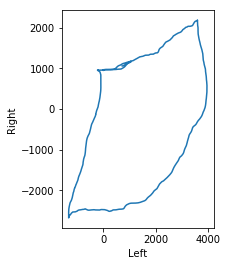

In [14]:
# Setup an array to store the encoder positions
left_motor = [] # initialize a empty list. You can add to a list with the left_motor.append(item) command
right_motor = [] # initialize an empty list

#different amplitude and phase combinations of your leg gait.    
    #
    #    Your code here to read encoder positions   
initial_time= time.monotonic()
current_time = time.monotonic()

while (current_time - initial_time) < 30: #gives 30 second to manually move the legs
    state = get_encoder_state()
    left_motor = left_motor + [state[2]];
    right_motor = right_motor +[state[0]];
    current_time = time.monotonic()

plt.subplot(1,2,1)
plt.plot(left_motor, right_motor)
plt.xlabel('Left')
plt.ylabel('Right')


Text(0,0.5,'Right')

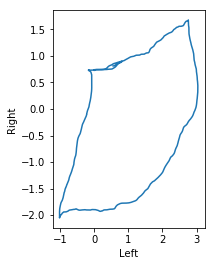

In [15]:
import sympy
from sympy import pi

#pi = 3.1415926
calibration_0 = 2048*2/pi
calibration = []
leng=len(left_motor)  

for i in range(leng):
    calibration = calibration + [calibration_0]
left_motor_pi = list(map(lambda x: x[0]/x[1], zip(left_motor,calibration))) 
right_motor_pi = list(map(lambda x: x[0]/x[1], zip(right_motor,calibration))) 

# Plot the results using encoder values (centered on your new home) and scaled to be between -pi, pi
plt.subplot(1,2,2)
plt.plot(left_motor_pi, right_motor_pi)
plt.xlabel('Left')
plt.ylabel('Right')

In [16]:
#
# After we finished problem 4, we have to adjusted position and velocity gain to a proper values 
# get prepared for problem 5 
m0.config.pos_gain=10;
m1.config.pos_gain=10;
m0.config.vel_gain=10.0/10000.0;
m1.config.vel_gain=10.0/10000.0;

In [17]:
zero()

## Problem 5: Command a simple cyclic gait of the leg

__5.1__ In this last problem we will command a simple cyclic gait of the leg by sending sinusoidal position commands to the motors and exploring how phase and amplitude differences influence the foot motion. Record the encoder position while running the gait and provide plots of the motor angles as a function of time. Additionally, take a video of each gait and post it to youtube, including a link in the notebook at the very bottom. You can include youtube videos by entering the command ```YouTubeVideo('video_code')``` in a code cell, where video code is found from the youtube page.

*Provide plots and videos for three different gaits*


In [23]:
import sympy
from sympy import sin, cos, asin, acos, pi
#
# Let's first define a function for simple cyclic gait movement
#
# For simple expression about sinusoidal signal here
# theta = A * sin(w * t + inip) + k
# where, A is Amplitude, stands for: Amplitude_left or Amplitude_right
# w is Angular velocity, stands for: Phase_left or Phase_right
# inip is Initial phase, set inip=0 in our problem
# k is Offset

def simple_cyclic_gait(Amplitude_left,Amplitude_right,Phase_left,Phase_right,k1,k2):
    initial_time = time.monotonic()  # record the current time
    current_time = time.monotonic() 
    theta_left=[]
    theta_right=[]
    zero()
    time.sleep(2)
    while (current_time - initial_time) < 10:
        current_time = time.monotonic()
        t = current_time - initial_time
        theta_left = theta_left + [Amplitude_left * sin(Phase_left * t)+k1];
        theta_right = theta_right + [Amplitude_right * sin(Phase_right * t)+k2];
        leng=len(theta_left)
        move_motors(theta_right[leng-1],theta_left[leng-1],home_position)
        time.sleep(.01)
    return(theta_left,theta_right)

In [24]:
#
# Define a gait plot function for ploting the motor angles as a function of time.
#

def gait_plot(gait_left,gait_right):
    T=len(gait_left);
    ti = []
    for i in range(T):
        ti = ti + [i]
    tim = list(map(lambda x: x[0]*(10/T), zip(ti))) 
    plt.plot(tim,gait_left,'r')
    plt.plot(tim,gait_right,'b')
    plt.xlabel('time(s)')
    plt.ylabel('theta')


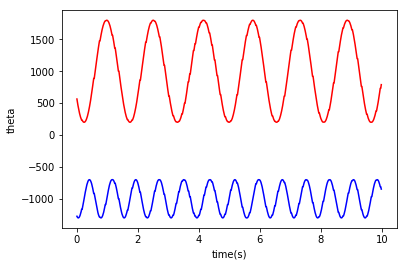

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

#
#  Plot for gait 1
#
# The parameters for gait 1 plot are described as follow:

#Amplitude_left = 800 
#Amplitude_right = -300 
#Phase_left = 5 
#Phase_right = 10 
#k1=1000;
#k2=-1000;

theta = simple_cyclic_gait(800,-300,5,10,1000,-1000)
gait1_left = theta[0];
gait1_right = theta[1];
gait_plot(gait1_left,gait1_right)

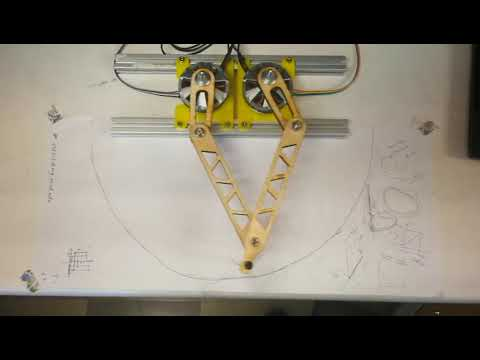

In [30]:
from IPython.display import YouTubeVideo
#  Youtube video for gait 1
#
YouTubeVideo('SMg5FKrC7hc')

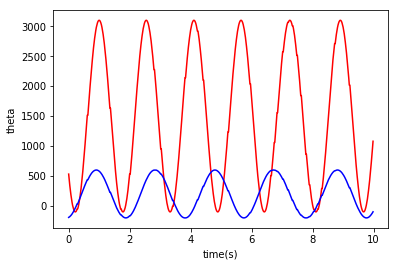

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

#
#  Plot for gait 2
#
# The parameters for gait 2 plot are described as follow:

#Amplitude_left = 1600 
#Amplitude_right = -400 
#Phase_left = 5 
#Phase_right = 5 
#k1=1500;
#k2=200;

theta = simple_cyclic_gait(1600,-400,5,4,1500,200)
gait2_left = theta[0];
gait2_right = theta[1];
gait_plot(gait2_left,gait2_right)

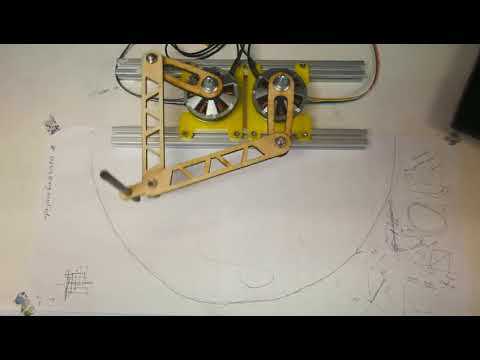

In [31]:
#
#  Youtube video for gait 2
#
from IPython.display import YouTubeVideo
#  Youtube video for gait 1
#
YouTubeVideo('u-BZexA8iH8')

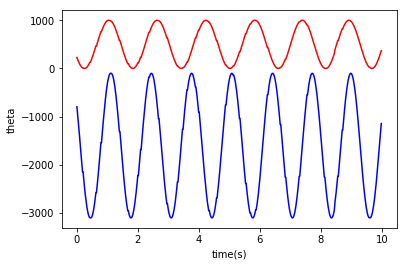

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

#
#  Plot for gait 3
#
# The parameters for gait 3 plot are described as follow:

#Amplitude_left = 500
#Amplitude_right = -1500 
#Phase_left = 5 
#Phase_right = 6
#k1=500;
#k2=-1600;

theta = simple_cyclic_gait(500,-1500,5,6,500,-1600)
gait2_left = theta[0];
gait2_right = theta[1];
gait_plot(gait2_left,gait2_right)

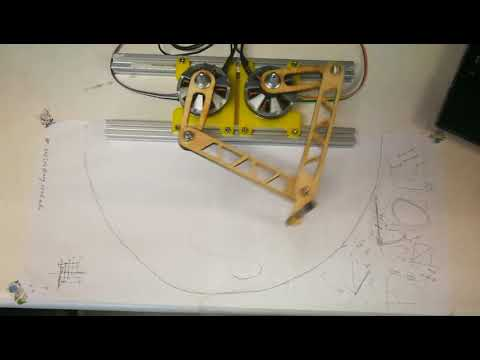

In [32]:
#
#  Youtube video for gait 3
#
from IPython.display import YouTubeVideo
#  Youtube video for gait 1
#
YouTubeVideo('iSe0DHMtbkU')

In [29]:
zero()